# 15 - Loading Multiple Well Log LAS Files Using Python
  
**Created By:** Andy McDonald  
**Link to Article:** https://andymcdonaldgeo.medium.com/loading-multiple-well-log-las-files-using-python-39ac35de99dd

Log ASCII Standard (LAS) files are a common Oil & Gas industry format for storing and transferring well log data. The data contained within is used to analyze and understand the subsurface, as well as identify potential hydrocarbon reserves. In my previous article: Loading and Displaying Well Log Data, I covered how to load a single LAS file using the LASIO library.

In this article, I expand upon that by showing how to load multiple las files from a subfolder into a single pandas dataframe. Doing this allows us to work with data from multiple wells and visualize the data quickly using matplotlib. It also allows us to prepare the data in a single format that is suitable for running through Machine Learning algorithms.

This notebook forms part of my Python & Petrophysics series. The full series can be found here. For the examples below you can find my Jupyter Notebook and dataset on my GitHub repository at the following link.

## Setting up the Libraries
The first step is to bring in the libraries we will be working with. We will be using five libraries: pandas, matplotlib, seaborn, os, and lasio. 

Pandas, os and lasio will be used to load and store our data, whereas matplotlib and seaborn will allow us to visualize the contents of the wells.

In [1]:
# Libraries for data loading
import lasio
import pandas as pd
import os

# Libraries for data visualization:
import matplotlib.pyplot as plt
import seaborn as sns

Next we are going setup an empty list which will hold all of our las file names.

Secondly, in this example we have our files stored within a sub folder called `Data/15-LASFiles/`. This will change depending on where your files are stored.

In [2]:
# Read the Files

las_file_list = []
path = 'Data/15-LASFiles/'

We can now use the `os.listdir` method and pass in the file path. When we run this code, we will be able to see a list of all the files in the data folder.

In [3]:
# View contents of the path, we will see LAS files plus an ASCII file
files = os.listdir(path)
files

['L05B03_comp.las',
 '.DS_Store',
 'L0507_comp.las',
 'L0506_comp.las',
 'L0509_comp.las',
 'WLC_PETRO_COMPUTED_1_INF_1.ASC']

From this code, we get a list of four LAS files and one ASCII file in the data folder. It may be the case that you have your LAS files mixed in with others files. In the next section we will see how to select only the LAS files.

## Reading the LAS Files

As you can see above, we have returned 4 LAS files and 1 ASC file. As we are only interested in the LAS files we need to loop through each file and check if the extension is .las. Also, to catch any cases where the extension is capitalized (.LAS instead of .las), we need to call upon `.lower()` to convert the file extension string to lowercase characters. 
 
Once we have identified if the file ends with .las, we can then add the path ('Data/15-LASFiles/') to the file name. This is required for lasio to pick up the files correctly. If we only passed the file name, the reader would be looking in the same directory as the script or notebook, and would fail as a result.

In [4]:
for file in files:
    if file.lower().endswith('.las'):
        las_file_list.append(path + file)
        
las_file_list

['Data/15-LASFiles/L05B03_comp.las',
 'Data/15-LASFiles/L0507_comp.las',
 'Data/15-LASFiles/L0506_comp.las',
 'Data/15-LASFiles/L0509_comp.las']

When we call the las_file_list we can see the full path for each of the 4 LAS files.

## Appending the LAS Files to a Dataframe

There are a number of different ways to concatenate and / or append data to dataframes. In this article we will use a simple method of create a list of dataframes, which we will concatenate together.
First, we will create an empty list using `df_list=[]`. Then secondly, we will loop through the las_file_list, read the file and convert it to a dataframe.

It is useful for us to to know where the data originated. If we didn't retain this information, we would end up with a dataframe full of data with no information about it's origins. To do this, we can create a new column and assign the well name value:  `lasdf['WELL']=las.well.WELL.value`. This will make it easy to work with the data later on.

Additionally, as lasio sets the dataframe index to the depth value from the file, we can create an additional column called DEPTH.

In [5]:
df_list = []

for lasfile in las_file_list:
    las = lasio.read(lasfile)
    lasdf = las.df()
    
    lasdf['WELL'] = las.well.WELL.value
    lasdf['DEPTH'] = lasdf.index
    df_list.append(lasdf)


We will now create a working dataframe containing all of the data from the LAS files by concatenating the list objects.

In [6]:
workingdf = pd.concat(df_list, sort=True)

When we call upon the working dataframe, we can see that we have our data from multiple wells in the same dataframe.

In [7]:
workingdf

,DEPTH,DRHO,DT,GR,NPHI,RHOB,WELL
DEPT,,,,,,,
5129.9004,5129.9004,-0.014551,NaN,NaN,0.203298,2.610764,L05-B-03
5129.8004,5129.8004,-0.013249,NaN,NaN,0.203530,2.618879,L05-B-03
5129.7004,5129.7004,-0.011755,NaN,NaN,0.204970,2.622911,L05-B-03
5129.6004,5129.6004,-0.014683,NaN,NaN,0.204624,2.613203,L05-B-03
5129.5004,5129.5004,-0.016817,NaN,NaN,0.204205,2.603054,L05-B-03
...,...,...,...,...,...,...,...
4879.3006,4879.3006,NaN,NaN,104.244873,NaN,NaN,L05-B-01
4879.4006,4879.4006,NaN,NaN,104.248474,NaN,NaN,L05-B-01
4879.5006,4879.5006,NaN,NaN,104.088211,NaN,NaN,L05-B-01


We can also confirm that we have all the wells loaded by checking for the unique values within the well column:

In [8]:
workingdf['WELL'].unique()

array(['L05-B-03', 'L05-07', 'L05-06', 'L05-B-01'], dtype=object)

## Making Quick Data Visualizations
Now that we have our data loaded into a pandas dataframe object, we can create some simple and quick multi-plots to gain insight into our data. We will do this using crossplot/scatterplots, a boxplot and a Kernel Density Estimate (KDE) plot.  

To start this, we first need to group our dataframe by the well name using the following:

In [9]:
grouped = workingdf.groupby('WELL')

### Crossplot / Scatterplots Per Well

Crossplots (also known as scatterplots) are used to plot one variable against another. For this example we will use a neutron porosity vs bulk density crossplot, which is a very common plot used in petrophysics.

Using a similar piece of code that was previously mentioned on my Exploratory Data Analysis With Well Log Data article, we can loop through each of the groups in the dataframe and generate a crossplot (scatter plot) of neutron porosity (NPHI) vs bulk density (RHOB).

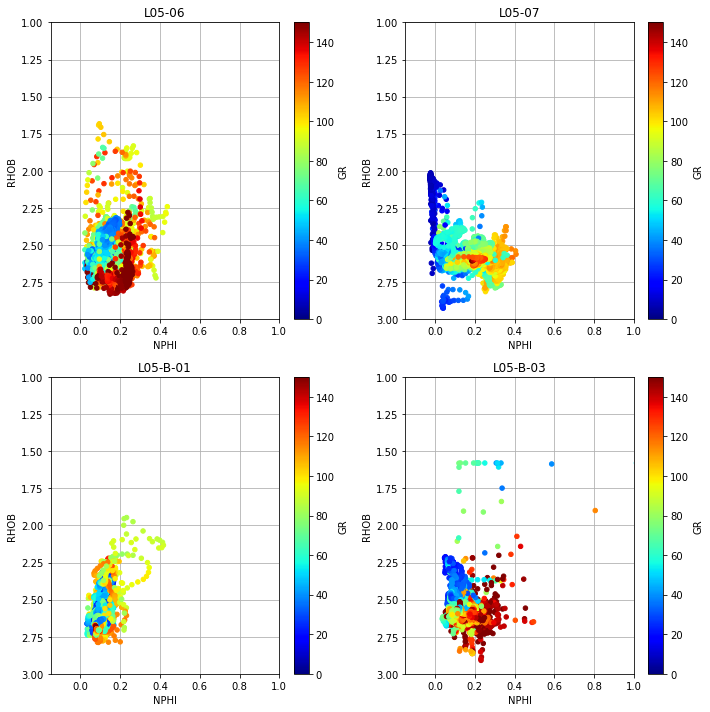

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(10,10))

for (name, df), ax in zip(grouped, axs.flat):
    df.plot(kind='scatter', x='NPHI', y='RHOB', ax=ax, c='GR', cmap='jet', vmin=0, vmax=150)
    ax.set_xlim(-0.15,1)
    ax.set_ylim(3,1)
    ax.set_title(name)
    ax.grid(True)
    ax.set_axisbelow(True)
plt.tight_layout()

### Boxplot of Gamma Ray Per Well
Next up, we will display a boxplot of the gamma ray cuvre from all wells. The box plot will show us the extent of the data (minimum to maximum), the quartiles, and the median value of the data.

This can be achieved using a single line of code in the seaborn library. In the arguments we can pass in the workingdf dataframe for data, and the WELL column for the hue. The latter of which will split the data up into individual boxes, each with it's own unique color.

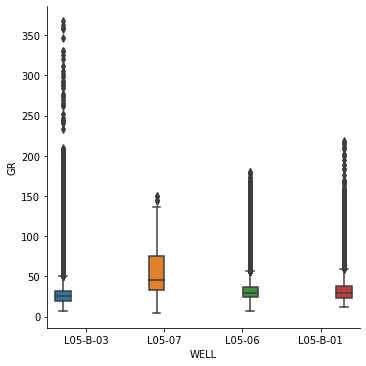

In [11]:
sns.catplot(x='WELL', y='GR', hue='WELL', data=workingdf, kind='box')

### Histogram (Kernel Density Estimate) 
Finally, we can view the distribution of the values of a curve in the dataframe by using a Kernel Density Estimate plot, which is similar to a histogram.

Again, this example shows another way to apply the groupby function. We can tidy up the plot by calling up matplotlib functions to set the x and y limits.

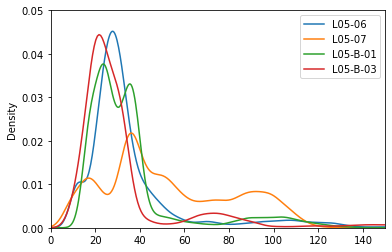

In [12]:
workingdf.groupby('WELL').GR.plot(kind='kde')
plt.xlim(0,150)
plt.ylim(0, 0.05) #ylim upper may change depending on data
plt.legend()

### Summary
In this notebook we have covered how to load multiple LAS files by searching a directory for all files with a .las extension and concatenate them into a single pandas dataframe. Once we have this data in a dataframe, we can easily call upon matplotlib and seaborn to make quick and easy to understand visualizations of the data.

***Thanks for reading!***

*If you have found this article useful, please feel free to check out my other articles looking at various aspects of Python and well log data. You can also find my code used in this article and others at GitHub.*

*If you want to get in touch you can find me on LinkedIn or at my website.*

*Interested in learning more about python and well log data or petrophysics? Follow me on [Medium](https://medium.com/@andymcdonaldgeo).*